In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


This is a medical [dataset](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset) with some features that probably can help predict heart attacks. In this notebook I will do:

- Some visual analysis and show some relationships between features
- Fit predictive models
- Adjust recall metric to 95% for chosen model
- Summaryze some observations

In [2]:
# import moduls
import seaborn as sns
sns.set_style('darkgrid') # set grid for all graphs
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from collections import Counter

# Discription of variables in data set

About this dataset
Age : Age of the patient

Sex : Sex of the patient

exang: exercise induced angina (1 = yes; 0 = no)

ca: number of major vessels (0-3)

cp : Chest Pain type chest pain type (Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4: asymptomatic)

trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach : maximum heart rate achieved

target : 0= less chance of heart attack 1= more chance of heart attack

# Loading data and first sight at data frame

In [3]:
data = pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')

In [4]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
data.shape

(303, 14)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


We have only numeric (int, float) types

In [7]:
data.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Data doesn't have missing values

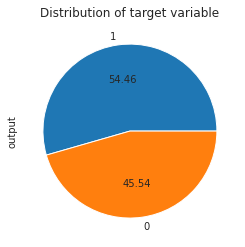

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set(title='Distribution of target variable')
data.output.value_counts().plot(kind='pie', autopct="%.2f")
plt.show()

In [9]:
for col in data.columns:
    n = data[col].nunique()
    print(col + " has %s unique values" %n)

age has 41 unique values
sex has 2 unique values
cp has 4 unique values
trtbps has 49 unique values
chol has 152 unique values
fbs has 2 unique values
restecg has 3 unique values
thalachh has 91 unique values
exng has 2 unique values
oldpeak has 40 unique values
slp has 3 unique values
caa has 5 unique values
thall has 4 unique values
output has 2 unique values


We see here that some of variables have 2-5 unique values. I will treat it like categorical variables. Collect numeric and categorical columns separetly

In [10]:
num_cols = [col for col in data.columns if data[col].nunique() > 5]
cat_cols = [col for col in data.columns if data[col].nunique() <= 5]
print('Numeric columns are:', num_cols, 'Categorical columns are:', cat_cols, sep='\n')

Numeric columns are:
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical columns are:
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']


In [11]:
data[num_cols].describe()

,age,trtbps,chol,thalachh,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


Distribution of numeric data

# Visialization

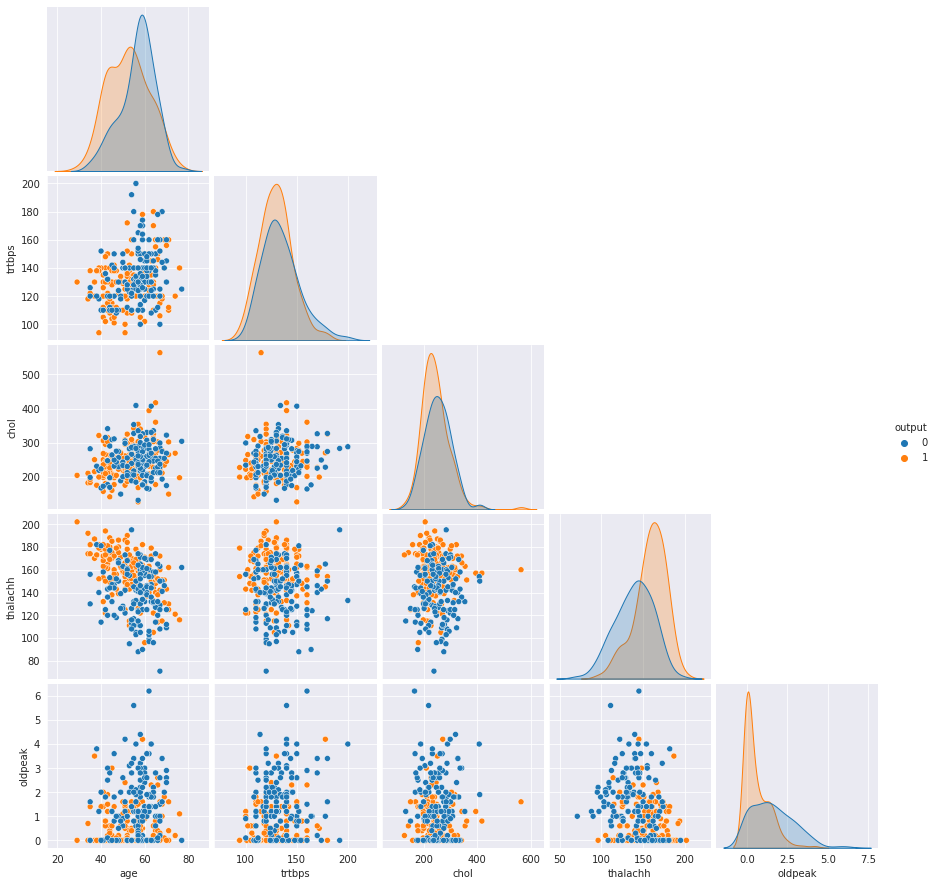

In [12]:
sns.pairplot(data, vars=num_cols, hue='output', corner=True)
plt.show()

**Conclusions:**
* It doesn't look like any variables have correlation. Maybe only 'thalachh' and 'age' have light negative correlation.
* Interesting histigrams of 'oldpeak'. Most of observations have low 'oldpeak' (< 2) but most of all have chance of heart attack.
* Interesting histigrams of 'thalachh': we can say that maximum heart rate can increase chance of heart attack.

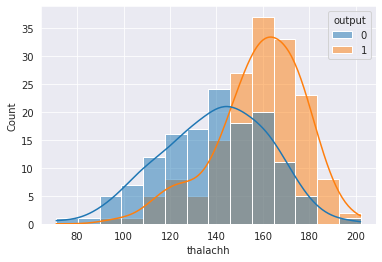

In [13]:
sns.histplot(data=data, x="thalachh", hue="output", kde=True)
plt.show()

**Not all variables were described on dataset page, I took this one from [disscusions](http://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/234843):**

1. age - age in years

2. sex - sex (1 = male; 0 = female)

3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)

4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)

5. chol - serum cholestoral in mg/dl

6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

7. restecg - resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)

8. thalach - maximum heart rate achieved

9. exang - exercise induced angina (1 = yes; 0 = no)

10. oldpeak - ST depression induced by exercise relative to rest

11. slope - the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)

12. ca - number of major vessels (0-3) colored by flourosopy

13. thal - 2 = normal; 1 = fixed defect; 3 = reversable defect

14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

Thanks to [jaykumar1607](http://www.kaggle.com/jaykumar1607)

**Here I would like to examine dependance "chance of heart attack" and other features. But at first I have to convert some numeric data to categorical (do binning)**

In [14]:
cat_data = data.copy()

In [15]:
cat_data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Binning and rename values

In [16]:
# function for calculation max heart rate ('thalachh') normal/critical for person
# it calculates as: 220 - age, and then compare with value in 'thalachh' columns

def calc_max_pulse(col_max_heart_rate, col_age):
    x = np.array(col_max_heart_rate)
    y = np.array(col_age)
    changed_array = []
    for n in range(len(x)):
        if (x[n]) <= (220 - y[n]):
            changed_array.append('normal')
        else: 
            changed_array.append('critical')
    return changed_array

In [17]:
## binning of numerical variables

cat_data['trtbps'] = pd.cut(cat_data['trtbps'], bins = [0, 120, 129, 139, 159, 179, 10000], labels = ['Optimal', 'Normal', 'High normal', 
                                                                                              'Grade 1 hypertension', 'Grade 2 hypertension',
                                                                                              'Grade 3 hypertension'])

cat_data['thalachh'] = calc_max_pulse(cat_data['thalachh'], cat_data['age'])

cat_data['age'] = pd.cut(cat_data['age'], bins = [0,45,60,200], labels = ['Adults','Mid Adults','Elderly'])

cat_data['chol'] = pd.cut(cat_data['chol'], bins = [0, 200, 239, 600], labels = ['Ideal', 'Borderline high', 'High'])


[Binning blood pressure](http://en.wikipedia.org/wiki/Blood_pressure)

[Age binnig](http://kidspicturedictionary.com/english-through-pictures/people-english-through-pictures/age-physical-description/) thanks to [bhuvanchennoju](http://www.kaggle.com/bhuvanchennoju) and his [great notebook](https://www.kaggle.com/bhuvanchennoju/data-stroytelling-auc-focus-on-strokes#Summary)

[Cholesterol level](http://www.cholesterolmenu.com/cholesterol-levels-chart/)
I suspect that our data['chol'] is 'Total cholesterol'

**Rename features for more informative graphs**

In [18]:
cat_data['sex'].replace({0: 'female', 1: 'male'},inplace=True)
cat_data['cp'].replace({1: 'typical angina', 2: 'atypical angina', 3: 'non-anginal pain', 0: 'asymptomatic'},inplace=True)
cat_data['output'].replace({0: 'less risk', 1: 'risk'},inplace=True)
cat_data['fbs'].replace({0: 'blood sugar less 120 mg/dl', 1: 'blood sugar more 120 mg/dl'},inplace=True)
cat_data['restecg'].replace({1: 'normal', 2: 'having ST-T wave abnormality', 0: 'hypertrophy'},inplace=True)
cat_data['exng'].replace({0: 'no exercise', 1: 'exercise induced angina'},inplace=True)
cat_data['slp'].replace({0: 'downsloping', 1: 'flat', 2: 'upsloping'},inplace=True)
cat_data['caa'].replace({0: '0 major vessel', 1: '1 major vessel', 2: '2 major vessels', 3: '3 major vessels', 4: '4 major vessels'},inplace=True)
cat_data['thall'].replace({1: 'fixed defect', 2: 'normal', 3: 'reversable defect'},inplace=True)

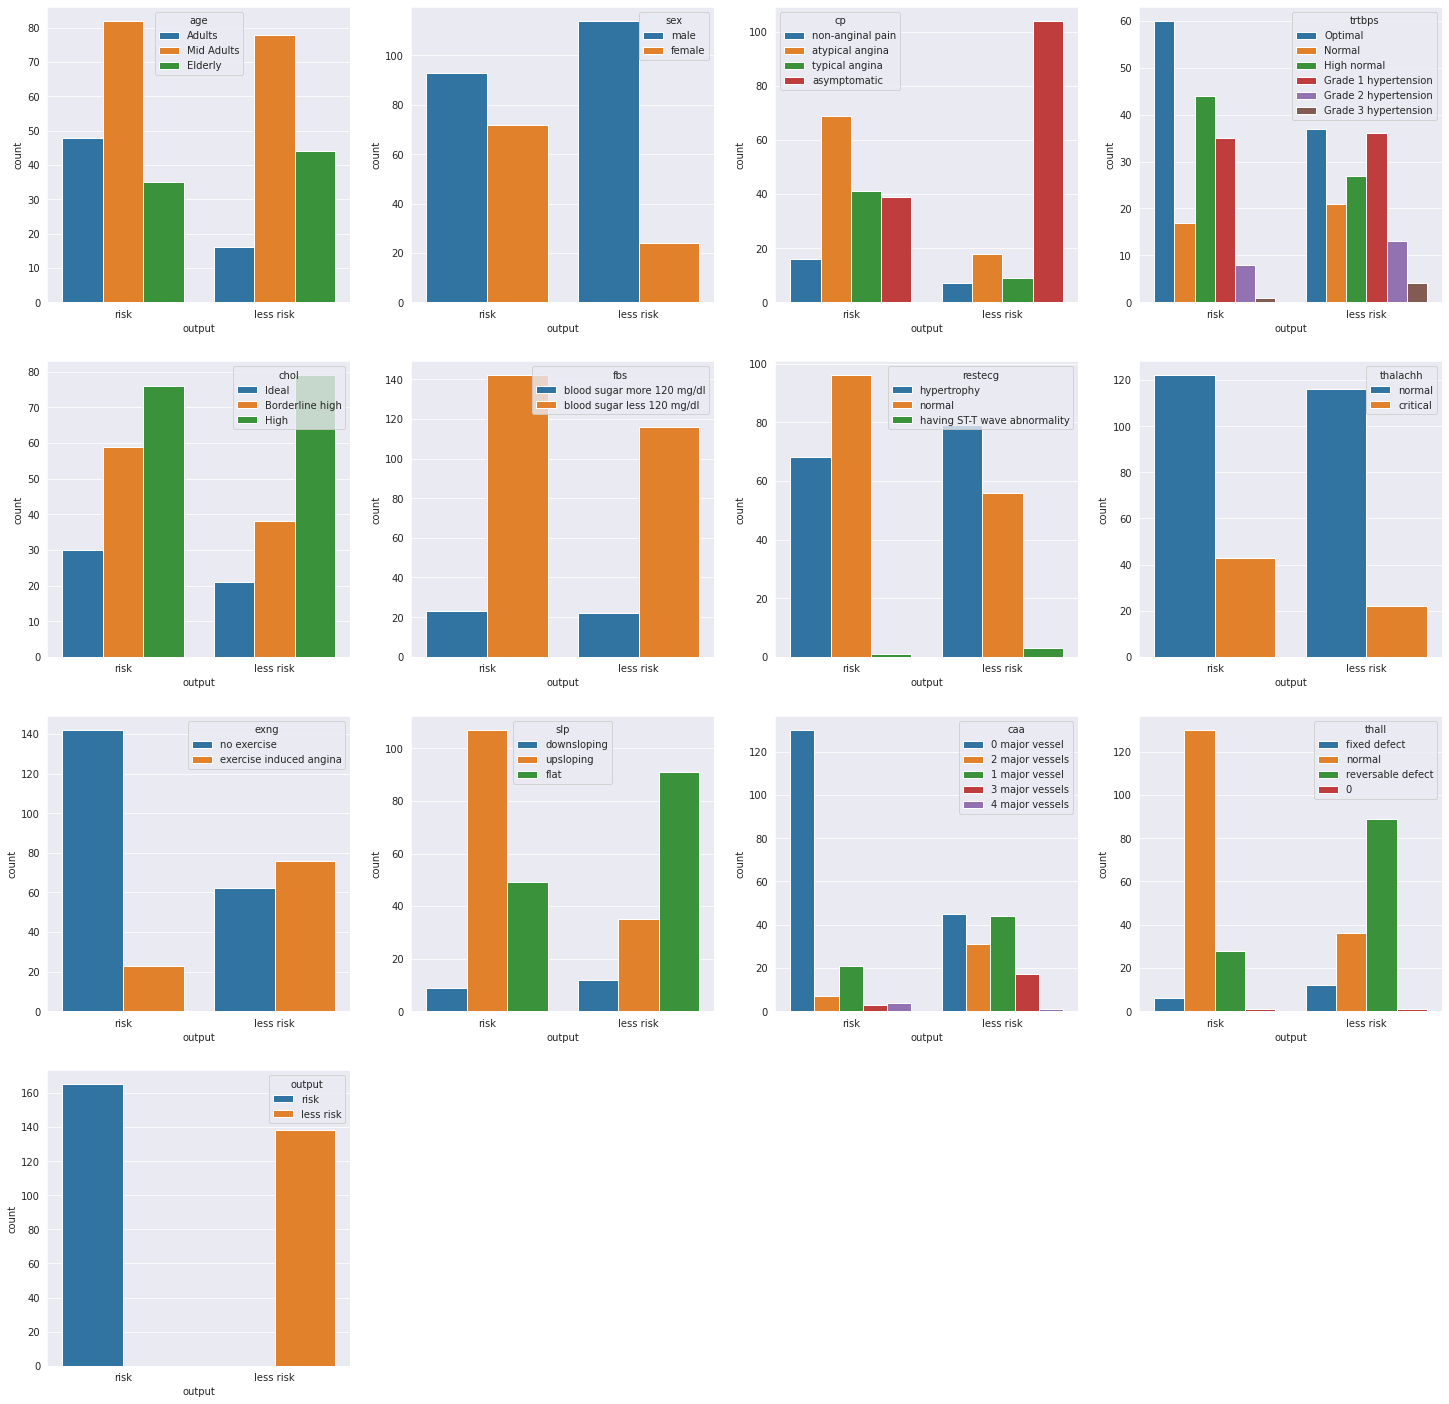

In [19]:
fig = plt.figure(figsize=(25,25))
n = 1
for column in cat_data.drop('oldpeak', axis=1):
    ax = plt.subplot(4,4,n)
    sns.countplot(x='output', hue=column, data=cat_data)
    n += 1
plt.show()

**Conclusions:** 
* Women more vulnerable than men
* Chest pain (cp) angina (typical/atypical) can indicate people who have a risk
* A bit confusing: we have more risk obsertation in "Optimal" blood pressure (trtbps) group and "Normal" group in esting electrocardiographic results (restecg). thall = "normal" the same
* Cholesterol and blood sugar don't informative for us
* "Exng", "slp", "caa" have one strong tendence in risk group
* Some strange value for feature 'thall' = 0. It wasn't described anywhere.


I would say this plots a bit confusing. I thought that it would be some correlation between high rate of heart rate and cholesterol or elderly people would have more chance to be in risk but it doesn't observed.

In [20]:
cat_data[(cat_data['thall'] == 0)]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
48,Mid Adults,female,atypical angina,Normal,Borderline high,blood sugar less 120 mg/dl,hypertrophy,normal,no exercise,0.0,upsloping,0 major vessel,0,risk
281,Mid Adults,male,asymptomatic,Normal,Borderline high,blood sugar more 120 mg/dl,normal,normal,exercise induced angina,1.0,flat,0 major vessel,0,less risk


In [21]:
cat_data.groupby(['output', 'thall']).agg({'output': 'count'})

output
output    thall                    
less risk 0                       1
          fixed defect           12
          normal                 36
          reversable defect      89
risk      0                       1
          fixed defect            6
          normal                130
          reversable defect      28

We have 2 observations. One in risk col and another in less risk col. I will change "thall = 0" values to most frequent in "risk" and "less risk" groups

In [22]:
cat_data.loc[((cat_data['thall'] == 0) & (cat_data['output'] == 'less risk')), ('thall')] = 'reversable defect'

In [23]:
cat_data.loc[((cat_data['thall'] == 0) & (cat_data['output'] == 'risk')), ('thall')] = 'normal'

In [24]:
cat_data.groupby(['output', 'thall']).agg({'output': 'count'})

output
output    thall                    
less risk fixed defect           12
          normal                 36
          reversable defect      90
risk      fixed defect            6
          normal                131
          reversable defect      28

Check correlations between features (I use main data without binning)

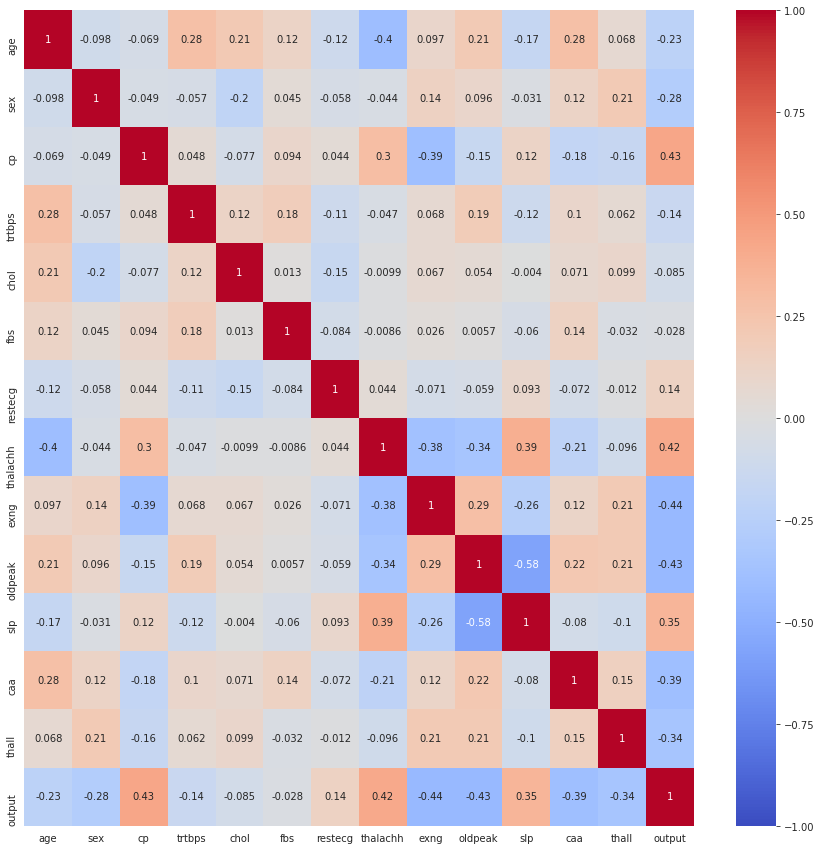

In [25]:
fig = plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

* The strongest correlation between features "slp" and "oldpeak". And it's negative correlation
* Target feature "output" has stronger possitive correlation with "cp", "thalach" and stronger negative correlation with "exng", "oldpeak".

# Preparation data for modeling

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [27]:
Counter(data.output)

Counter({1: 165, 0: 138})

As we can see target variable is balanced and we haven't to do "undersampling" or "oversampling" things. Just separate our data with "train_test_split"

In [28]:
X = data.drop('output', axis=1)
y = data.output

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

**I would like check difference between raw data, normalized and binning data. I will do 2 new data frame. First ("scaled_X_train") with normalized train data (using Standart Scaler), second ("encodered_X_train") with transformed numeric columns to categorical (binning like I did above and then use Label Encoder). And compare the results.**

In [30]:
scaled_X_train = X_train.copy()

In [31]:
scaled_X_train.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
173,58,1,2,132,224,0,0,173,0,3.2,2,2,3
261,52,1,0,112,230,0,1,160,0,0.0,2,1,2
37,54,1,2,150,232,0,0,165,0,1.6,2,0,3
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3
166,67,1,0,120,229,0,0,129,1,2.6,1,2,3


In [32]:
array = ['age', 'trtbps', 'chol', 'thalachh']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(scaled_X_train[array])
normalize_results = pd.DataFrame(X_train_scaled, index=scaled_X_train.index, columns=array)
scaled_X_train.drop(array, axis=1, inplace=True)
scaled_X_train = scaled_X_train.join(normalize_results)

In [33]:
scaled_X_train.head()

,sex,cp,fbs,restecg,exng,oldpeak,slp,caa,thall,age,trtbps,chol,thalachh
173,1,2,0,0,0,3.2,2,2,3,0.352565,0.020206,-0.435970,1.011893
261,1,0,0,1,0,0.0,2,1,2,-0.310686,-1.140980,-0.325394,0.453640
37,1,2,0,0,0,1.6,2,0,3,-0.089602,1.065272,-0.288536,0.668352
101,1,3,0,0,0,4.2,0,0,3,0.463107,2.690932,0.411776,-0.190498
166,1,0,0,0,1,2.6,1,2,3,1.347442,-0.676506,-0.343823,-0.877579


***We do scaling after splitting for excluding data leakage in test data!!***

In [34]:
encodered_X_train = X_train.copy()

Do the same I did before in binning section

In [35]:
encodered_X_train['trtbps'] = pd.cut(encodered_X_train['trtbps'], bins = [0, 120, 129, 139, 159, 179, 10000], labels = ['Optimal', 'Normal', 'High normal', 
                                                                                              'Grade 1 hypertension', 'Grade 2 hypertension',
                                                                                              'Grade 3 hypertension'])

encodered_X_train['thalachh'] = calc_max_pulse(encodered_X_train['thalachh'], encodered_X_train['age'])

encodered_X_train['age'] = pd.cut(encodered_X_train['age'], bins = [0,45,60,200], labels = ['Adults','Mid Adults','Elderly'])

encodered_X_train['chol'] = pd.cut(encodered_X_train['chol'], bins = [0, 200, 239, 600], labels = ['Ideal', 'Borderline high', 'High'])

In [36]:
encoder = LabelEncoder()
for title in array:
    encodered_X_train[title] = encoder.fit_transform(encodered_X_train[title])

In [37]:
# IT CAN BE USED INSTEAD OF LabelEncoder()

# col_for_dummy = ['age', 'cp', 'trtbps', 'chol', 'thalachh', 'slp', 'caa', 'thall']
# dummy_df = pd.get_dummies(encodered_X_train[col_for_dummy])
# encodered_X_train.drop(col_for_dummy, axis=1, inplace=True)
# dummy_X_train = pd.concat([encodered_X_train, dummy_df], axis=1)
# encodered_X_train = dummy_X_train

In [38]:
encodered_X_train.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
173,2,1,2,3,0,0,0,0,0,3.2,2,2,3
261,2,1,0,5,0,0,1,1,0,0.0,2,1,2
37,2,1,2,0,0,0,0,1,0,1.6,2,0,3
101,2,1,3,1,1,0,0,1,0,4.2,0,0,3
166,1,1,0,5,0,0,0,1,1,2.6,1,2,3


In [39]:
X_train.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
173,58,1,2,132,224,0,0,173,0,3.2,2,2,3
261,52,1,0,112,230,0,1,160,0,0.0,2,1,2
37,54,1,2,150,232,0,0,165,0,1.6,2,0,3
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3
166,67,1,0,120,229,0,0,129,1,2.6,1,2,3


Now we have 3 dataset for modeling

# Modeling

Import modeling moduls

In [40]:
# models
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             precision_recall_curve, roc_curve, 
                             plot_precision_recall_curve, plot_confusion_matrix)

# for regular expressions
import re 

Firstly, let's check which dataset fits more

In [41]:
models = [RandomForestClassifier(), GradientBoostingClassifier(), LogisticRegression(), KNeighborsClassifier(), AdaBoostClassifier(),
         DecisionTreeClassifier(), SVC(probability = True), XGBClassifier(eval_metric = 'logloss'), LGBMClassifier()]

model_names = []
train_data = [X_train, scaled_X_train, encodered_X_train]

for mod_name in models:
    r = re.findall((r'\w*'), str(mod_name))
    model_names.append(r[0])
    
for n in range(len(models)):
    clf = models[n]
    scores = cross_val_score(clf, train_data[0], y_train, cv=5)
    print('Algorithm is: %s' %model_names[n])
    print('Raw data accuracy:', scores.mean().round(3))
    scores = cross_val_score(clf, train_data[1], y_train, cv=5)
    print('Scaled data accuracy:', scores.mean().round(3))
    scores = cross_val_score(clf, train_data[2], y_train, cv=5)
    print('Encodered data accuracy:', scores.mean().round(3))
    print()

Algorithm is: RandomForestClassifier
Raw data accuracy: 0.824
Scaled data accuracy: 0.824
Encodered data accuracy: 0.824

Algorithm is: GradientBoostingClassifier
Raw data accuracy: 0.758
Scaled data accuracy: 0.758
Encodered data accuracy: 0.78

Algorithm is: LogisticRegression
Raw data accuracy: 0.828
Scaled data accuracy: 0.833
Encodered data accuracy: 0.82

Algorithm is: KNeighborsClassifier
Raw data accuracy: 0.608
Scaled data accuracy: 0.802
Encodered data accuracy: 0.802

Algorithm is: AdaBoostClassifier
Raw data accuracy: 0.772
Scaled data accuracy: 0.772
Encodered data accuracy: 0.767

Algorithm is: DecisionTreeClassifier
Raw data accuracy: 0.74
Scaled data accuracy: 0.754
Encodered data accuracy: 0.736

Algorithm is: SVC
Raw data accuracy: 0.639
Scaled data accuracy: 0.82
Encodered data accuracy: 0.798

Algorithm is: XGBClassifier
Raw data accuracy: 0.802
Scaled data accuracy: 0.807
Encodered data accuracy: 0.797

Algorithm is: LGBMClassifier
Raw data accuracy: 0.789
Scaled d

KNN and SVC - sensitive for preparing data but in other cases deference is not significant. I prefer use scaled data

In [42]:
def cross_valid_scores(models_array, X_tr, y_tr):
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
        
    scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy', 'roc_auc']

    for n in models:
        clf = n
        scores = cross_validate(clf, X_tr, y_tr, cv=5, scoring=scoring)

        acc_mean = scores['test_accuracy'].mean().round(3)
        prec_mean = scores['test_precision_macro'].mean().round(3)
        rec_mean = scores['test_recall_macro'].mean().round(3)
        f1_mean = scores['test_f1_macro'].mean().round(3)
        roc_mean = scores['test_roc_auc'].mean().round(3)

        accuracy.append(acc_mean*100)
        precision.append(prec_mean*100)
        recall.append(rec_mean*100)
        f1.append(f1_mean*100)
        auc.append(roc_mean*100)
        
    results_df = pd.DataFrame({"Accuracy Score":accuracy,"Precision Score":precision,
                        "Recall Score":recall, "f1 Score":f1,"AUC Score":auc,
                        "Algorithm": model_names})
    
    results_df = (results_df.sort_values(by = 'AUC Score', ascending = False)
                  .reset_index(drop =  True))
    
    return results_df

In [43]:
scaled_X_test = X_test.copy()
X_test_scaled = scaler.transform(scaled_X_test[array])
normalize_results = pd.DataFrame(X_test_scaled, index=scaled_X_test.index, columns=array)
scaled_X_test.drop(array, axis=1, inplace=True)
scaled_X_test = scaled_X_test.join(normalize_results)

Normalized test set

In [44]:
scaled_X_test.head()

,sex,cp,fbs,restecg,exng,oldpeak,slp,caa,thall,age,trtbps,chol,thalachh
225,1,0,0,1,1,2.6,0,0,3,1.679068,0.774976,-1.357433,-1.049349
152,1,3,0,0,0,0.6,1,0,3,1.015817,2.226458,-0.380682,0.238927
228,1,3,0,0,0,0.2,1,0,3,0.463107,2.226458,0.743503,0.410697
201,1,0,0,0,1,2.8,1,1,3,0.573649,-0.386209,0.190625,-0.362269
52,1,2,0,1,0,1.8,1,3,3,0.794733,-0.095913,-0.306965,-0.147556


In [45]:
cross_valid_scores(models, scaled_X_train, y_train)

,Accuracy Score,Precision Score,Recall Score,f1 Score,AUC Score,Algorithm
0,83.3,84.2,82.8,82.9,90.2,LogisticRegression
1,82.9,83.0,82.6,82.6,89.5,RandomForestClassifier
2,82.0,84.2,81.1,81.3,89.1,SVC
3,80.7,80.8,80.4,80.5,87.1,XGBClassifier
4,78.9,79.4,78.6,78.6,86.7,LGBMClassifier
5,75.8,76.1,75.6,75.6,85.9,GradientBoostingClassifier
6,77.2,77.6,76.9,76.9,84.1,AdaBoostClassifier
7,80.2,81.2,79.6,79.6,84.0,KNeighborsClassifier
8,74.5,74.6,74.5,74.4,74.5,DecisionTreeClassifier


I will maximaze "Recall score" because in my opinion, we don't have to miss positvite class (heart risk). Below I'll use Logistic Regression for final model. 

# Logistic Regression tune with Grid Search

In [46]:
param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss', 'Recall': 'recall'}

grid_log_reg = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Log_loss')

grid_log_reg.fit(scaled_X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000e-05, 1.00010e-01, 2.00010e-01, 3.00010e-01, 4.00010e-01,
       5.00010e-01, 6.00010e-01, 7.00010e-01, 8.00010e-01, 9.00010e-01,
       1.00001e+00, 1.10001e+00, 1.20001e+00, 1.30001e+00, 1.40001e+00,
       1.50001e+00, 1.60001e+00, 1.70001e+00, 1.80001e+00, 1.90001e+00,
       2.00001e+00, 2.10001e+00, 2.20001e+00, 2.30001e+00, 2.40001e+00,
       2.50001e+00, 2.60001e+00, 2.70001e+00, 2.80001e+00, 2.90001e+00])},
             refit='Log_loss', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy',
                      'Log_loss': 'neg_log_loss', 'Recall': 'recall'})

In [47]:
grid_log_reg.cv_results_

{'mean_fit_time': array([0.00586371, 0.00715294, 0.0074162 , 0.00812993, 0.00827107,
        0.00885091, 0.00847859, 0.00871511, 0.00852594, 0.00856514,
        0.00856719, 0.00883107, 0.0088285 , 0.00872421, 0.00899153,
        0.0093019 , 0.00907235, 0.00897293, 0.00917993, 0.00916166,
        0.00932021, 0.00938721, 0.00919294, 0.00913792, 0.00926261,
        0.00971437, 0.00953355, 0.00938215, 0.00927553, 0.00949731]),
 'std_fit_time': array([0.00042464, 0.00017094, 0.00028681, 0.00010615, 0.00054218,
        0.00076609, 0.00044389, 0.00057943, 0.00036761, 0.000249  ,
        0.00039087, 0.00048385, 0.00035953, 0.00033077, 0.00044128,
        0.00050604, 0.00017214, 0.0001349 , 0.00028581, 0.00038614,
        0.00073846, 0.00070154, 0.00013624, 0.00015325, 0.00023469,
        0.00129469, 0.00027636, 0.00037658, 0.00052017, 0.00041986]),
 'mean_score_time': array([0.00764809, 0.00780578, 0.00760374, 0.00781665, 0.00803981,
        0.00808024, 0.00794501, 0.00786433, 0.00787892, 0.00

In [48]:
grid_log_reg.best_params_

{'C': 0.40001000000000003}

In [49]:
best_clf = grid_log_reg.best_estimator_

In [50]:
best_clf.score(scaled_X_train, y_train).round(2)*100

86.0

In [51]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for n in scoring:
    scores = cross_val_score(best_clf, scaled_X_train, y_train, cv=5, scoring=n).mean()
    print(n, round((scores),2)*100)

accuracy 83.0
precision 81.0
recall 90.0
f1 85.0
roc_auc 90.0


# Prediction

In [52]:
prediction = best_clf.predict(scaled_X_test)
probability = best_clf.predict_proba(scaled_X_test)

In [53]:
probability_train = best_clf.predict_proba(scaled_X_train)

In [54]:
print('Accuracy: ', round(accuracy_score(y_test, prediction),2)*100)
print('Precision: ', round(precision_score(y_test, prediction),2)*100)
print('Recall: ', round(recall_score(y_test, prediction),2)*100)
print('F1-score: ', round(f1_score(y_test, prediction),2)*100)
print()
print('Confusion matrix: ', confusion_matrix(y_test, prediction), sep='\n')

Accuracy:  83.0
Precision:  81.0
Recall:  91.0
F1-score:  86.0

Confusion matrix: 
[[24  9]
 [ 4 39]]


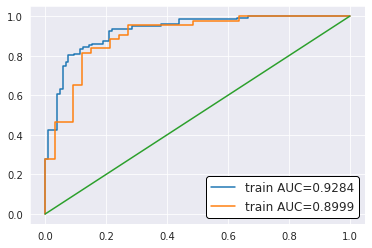

In [55]:
train_auc = roc_auc_score(y_train, probability_train[:, 1])
test_auc = roc_auc_score(y_test, probability[:, 1])

plt.figure()
plt.plot(*roc_curve(y_train, probability_train[:, 1])[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, probability[:, 1])[:2], label='train AUC={:.4f}'.format(test_auc))

legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))

plt.show()

# Gain Recall to 95% by specifying threshold for positive class

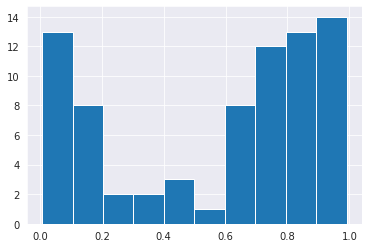

In [56]:
pd.Series(probability[:, 1]).hist()
plt.show()

Historgam of predicted probabilities. We can see the highest area between 0.4-0.5 in flat middle. I will adjust threshold = 0.4 to include this area in posotive class

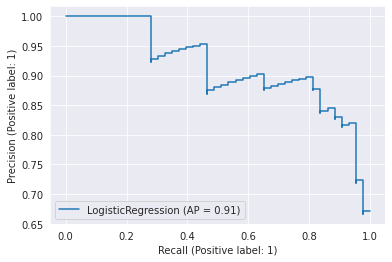

In [57]:
plot_precision_recall_curve(best_clf, scaled_X_test, y_test)

This is precision-recall curve where we can see dependence between these variables

In [58]:
prediction_with_threshold = np.where(probability[:, 1] > 0.4, 1, 0)

In [59]:
print('Accuracy with adjusted threshold: ', round(accuracy_score(y_test, prediction_with_threshold),2)*100)
print('Precision with adjusted threshold: ', round(precision_score(y_test, prediction_with_threshold),2)*100)
print('Recall with adjusted threshold: ', round(recall_score(y_test, prediction_with_threshold),2)*100)
print('F1-score with adjusted threshold: ', round(f1_score(y_test, prediction_with_threshold),2)*100)
print()
print('Confusion matrix with adjusted threshold: ', confusion_matrix(y_test, prediction_with_threshold), sep='\n')

Accuracy with adjusted threshold:  84.0
Precision with adjusted threshold:  80.0
Recall with adjusted threshold:  95.0
F1-score with adjusted threshold:  87.0

Confusion matrix with adjusted threshold: 
[[23 10]
 [ 2 41]]


# Summary:
* loaded few modules and looked through dataset
* binned some features
* visulaization of few relationships bewteen variables and individual variables.
* feature correaltion visualization
* prepared and compared dataset with different scaling
* chose algorithm with cross-validation
* tuned model with GridSearchCV
* gained recall to the specified value (95%).

**Thanks for reading**